In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchtext

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import time

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/quora-insincere-questions-classification/sample_submission.csv
/kaggle/input/quora-insincere-questions-classification/embeddings.zip
/kaggle/input/quora-insincere-questions-classification/train.csv
/kaggle/input/quora-insincere-questions-classification/test.csv


# Reading the data

In [2]:
%%time
# Unzip glove embeggins
!unzip ../input/quora-insincere-questions-classification/embeddings.zip
!rm ./wiki-news-300d-1M -r
!rm ./GoogleNews-vectors-negative300 -r
!rm ./paragram_300_sl999 -r

Archive:  ../input/quora-insincere-questions-classification/embeddings.zip
   creating: GoogleNews-vectors-negative300/
   creating: glove.840B.300d/
   creating: paragram_300_sl999/
   creating: wiki-news-300d-1M/
  inflating: glove.840B.300d/glove.840B.300d.txt  
  inflating: GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin  
  inflating: wiki-news-300d-1M/wiki-news-300d-1M.vec  
  inflating: paragram_300_sl999/README.txt  
  inflating: paragram_300_sl999/paragram_300_sl999.txt  
CPU times: user 3.28 s, sys: 542 ms, total: 3.82 s
Wall time: 3min 17s


In [3]:
%%time
# Getting glove vectors
glove_path = './glove.840B.300d/glove.840B.300d.txt'
glove = torchtext.vocab.Vectors(glove_path)

100%|█████████▉| 2196016/2196017 [03:30<00:00, 10437.32it/s]


CPU times: user 3min 38s, sys: 14.4 s, total: 3min 52s
Wall time: 4min 13s


In [4]:
%%time
test_csv  = pd.read_csv('../input/quora-insincere-questions-classification/test.csv')
train_csv = pd.read_csv('../input/quora-insincere-questions-classification/train.csv')

CPU times: user 3.59 s, sys: 375 ms, total: 3.96 s
Wall time: 5.68 s


In [5]:
train_csv.info(), test_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1306122 non-null  object
 1   question_text  1306122 non-null  object
 2   target         1306122 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 29.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375806 entries, 0 to 375805
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   qid            375806 non-null  object
 1   question_text  375806 non-null  object
dtypes: object(2)
memory usage: 5.7+ MB


(None, None)

In [6]:
train_csv.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [7]:
test_csv.head()

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


# Exploratory Data Analysis

## Tokenize sentences and look at their lengths

In [8]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('basic_english')

In [9]:
%%time
# Tokenize sentences in train and test sets
train_csv_tokenized = train_csv.copy()
test_csv_tokenized  = test_csv.copy()
train_csv_tokenized['question_text'] = train_csv['question_text'].apply(lambda x: tokenizer(x))
test_csv_tokenized['question_text']  = test_csv['question_text'].apply(lambda x: tokenizer(x))

CPU times: user 21.2 s, sys: 1.04 s, total: 22.3 s
Wall time: 22.3 s


(array([2.3000e+01, 1.9414e+04, 8.2210e+04, 9.4476e+04, 6.2192e+04,
        3.8077e+04, 2.4214e+04, 1.6343e+04, 1.1583e+04, 5.7650e+03,
        6.4340e+03, 4.3170e+03, 2.9310e+03, 2.1580e+03, 1.8710e+03,
        1.4730e+03, 1.0740e+03, 6.1500e+02, 3.6000e+02, 1.1600e+02,
        1.1000e+02, 3.4000e+01, 9.0000e+00, 4.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 1. ,  3.9,  6.8,  9.7, 12.6, 15.5, 18.4, 21.3, 24.2, 27.1, 30. ,
        32.9, 35.8, 38.7, 41.6, 44.5, 47.4, 50.3, 53.2, 56.1, 59. , 61.9,
        64.8, 67.7, 70.6, 73.5, 76.4, 79.3, 82.2, 85.1, 88. ]),
 <BarContainer object of 30 artists>)

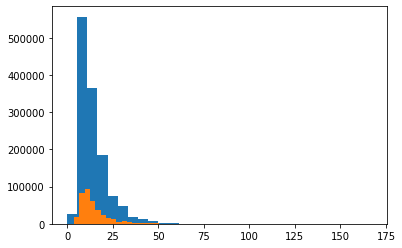

In [10]:
# Plot sentence lengths
plt.hist(train_csv_tokenized['question_text'].str.len(), bins=30)
plt.hist(test_csv_tokenized['question_text'].str.len(), bins=30)

Most sentences have less than 50 words, so lets choose 50 as max_len

## Checking word coverage

In [11]:
from collections import Counter

def get_word_count(rows):
    vocab = Counter()
    for r in rows:
        vocab.update(r)
        
    return vocab
    
def check_coverage(vocab, embedding):
    found = Counter()
    oov = Counter()
    itos = set(embedding.itos)
    for word in tqdm(vocab):
        if word in itos:
            found.update({word: vocab[word]})
        else:
            oov.update({word: vocab[word]})
            
    print("Percentage of unique words not found in GloVe: ", len(oov) / len(vocab) * 100, "%")
    print("Percentage of words not found in GloVe in total: ", sum(oov.values()) / sum(vocab.values()) * 100, "%")

    return found, oov

In [12]:
%%time
vocab = get_word_count(train_csv_tokenized['question_text'].values)
found, oov = check_coverage(vocab, glove)

100%|██████████| 260188/260188 [00:00<00:00, 362681.75it/s]

Percentage of unique words not found in GloVe:  47.389964179746954 %
Percentage of words not found in GloVe in total:  1.129196160941184 %
CPU times: user 6.28 s, sys: 72.2 ms, total: 6.35 s
Wall time: 6.35 s


In [13]:
oov.most_common(20)

[('i’m', 2573),
 ('don’t', 2244),
 ('what’s', 1817),
 ('it’s', 1077),
 ('can’t', 1039),
 ('quorans', 855),
 ('doesn’t', 814),
 ('100%', 661),
 ('i’ve', 582),
 ('isn’t', 540),
 ('didn’t', 503),
 ('cryptocurrencies', 497),
 ('brexit', 495),
 ('you’ve', 495),
 ('redmi', 382),
 ('you’re', 359),
 ('paytm', 351),
 ('kvpy', 350),
 ('iiser', 336),
 ('ethereum', 329)]

Most oov-s come from words that include ', ", $, -, and % symbols.

TODO: Split, remove or replace these symbols.

## Cleaning the data

In [14]:
def clean_and_tokenize(x):
    global tokenizer
        
    # Remove
    for c in ",“[]{}…‘":
        x = x.replace(c, '')
    # Add extra space
    for c in "%$^#/+&-|=<>\\*₹£":
        x = x.replace(c, f' {c} ')
    # Replace
    x = x.replace('’', "'").replace('”', '"').replace('`', "'").replace('´', "'").replace('™', ' tm ')
    # Add extra space
    x = x.replace('%', ' % ').replace('$', ' $ ').replace('^', ' ^ ').replace('#', ' # ').replace('/', ' / ').replace('+', ' + ').replace('&', ' & ')\
        .replace('-', ' - ').replace('|', ' | ').replace('=', ' = ').replace('>', ' > ').replace('<', ' < ').replace('\\', ' \ ').replace('*', ' * ')\
        .replace('₹', ' ₹ ').replace('£', ' £ ')
    
    return tokenizer(x)

In [15]:
%%time
# Tokenize sentences in train and test sets
train_csv_tokenized = train_csv
test_csv_tokenized  = test_csv
train_csv_tokenized['question_text'] = train_csv['question_text'].apply(lambda x: clean_and_tokenize(x))
test_csv_tokenized['question_text']  = test_csv['question_text'].apply(lambda x: clean_and_tokenize(x))

CPU times: user 39.1 s, sys: 511 ms, total: 39.6 s
Wall time: 39.7 s


(array([6.6156e+04, 1.9096e+05, 6.9765e+04, 2.7812e+04, 1.2556e+04,
        4.8990e+03, 2.7010e+03, 7.9100e+02, 1.3700e+02, 1.5000e+01,
        5.0000e+00, 3.0000e+00, 3.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1.  ,   8.24,  15.48,  22.72,  29.96,  37.2 ,  44.44,  51.68,
         58.92,  66.16,  73.4 ,  80.64,  87.88,  95.12, 102.36, 109.6 ,
        116.84, 124.08, 131.32, 138.56, 145.8 , 153.04, 160.28, 167.52,
        174.76, 182.  , 189.24, 196.48, 203.72, 210.96, 218.2 , 225.44,
        232.68, 239.92, 247.16

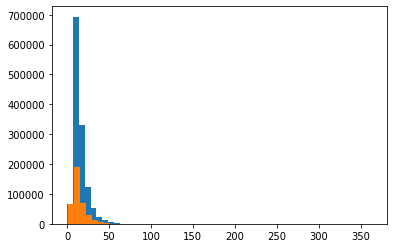

In [16]:
# Plot sentence lengths
plt.hist(train_csv_tokenized['question_text'].str.len(), bins=50)
plt.hist(test_csv_tokenized['question_text'].str.len(), bins=50)

In [17]:
%%time
vocab = get_word_count(train_csv_tokenized['question_text'].values)
found, oov = check_coverage(vocab, glove)

100%|██████████| 199679/199679 [00:00<00:00, 350784.92it/s]


Percentage of unique words not found in GloVe:  37.497683782470865 %
Percentage of words not found in GloVe in total:  0.6474193021414578 %
CPU times: user 6.38 s, sys: 44.8 ms, total: 6.43 s
Wall time: 6.43 s


In [18]:
oov.most_common(20)

[('quorans', 858),
 ('brexit', 524),
 ('cryptocurrencies', 499),
 ('redmi', 383),
 ('kvpy', 356),
 ('paytm', 355),
 ('iiser', 345),
 ('ethereum', 334),
 ('iisc', 278),
 ('₹', 227),
 ('jinping', 211),
 ('viteee', 186),
 ('iocl', 178),
 ('nmims', 163),
 ('rohingya', 157),
 ('upes', 157),
 ('fortnite', 156),
 ('coinbase', 149),
 ('nsit', 147),
 ('cpec', 146)]

## Comparing positive and negative targets

In [19]:
from wordcloud import WordCloud, STOPWORDS

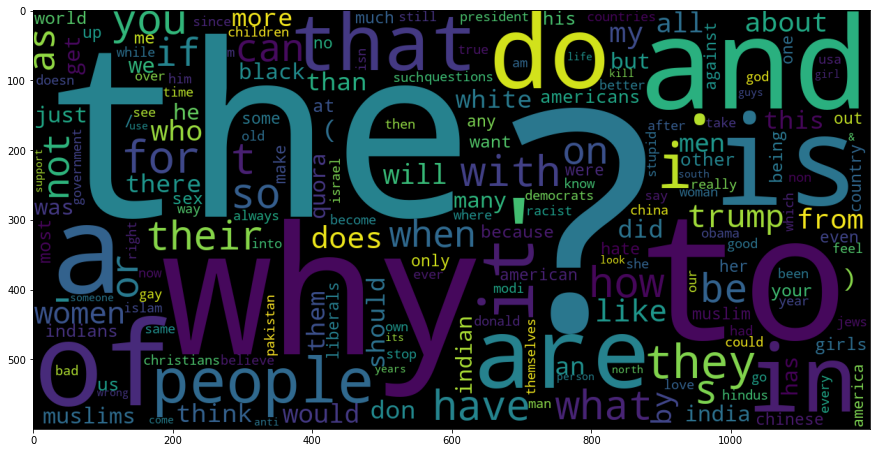

In [20]:
pos_vocab = get_word_count(train_csv_tokenized.loc[train_csv_tokenized['target'] == 1, 'question_text'].values)

plt.figure(figsize=(15,8))
plt.imshow(WordCloud(width=1200, height=600, stopwords=STOPWORDS).generate_from_frequencies(pos_vocab))

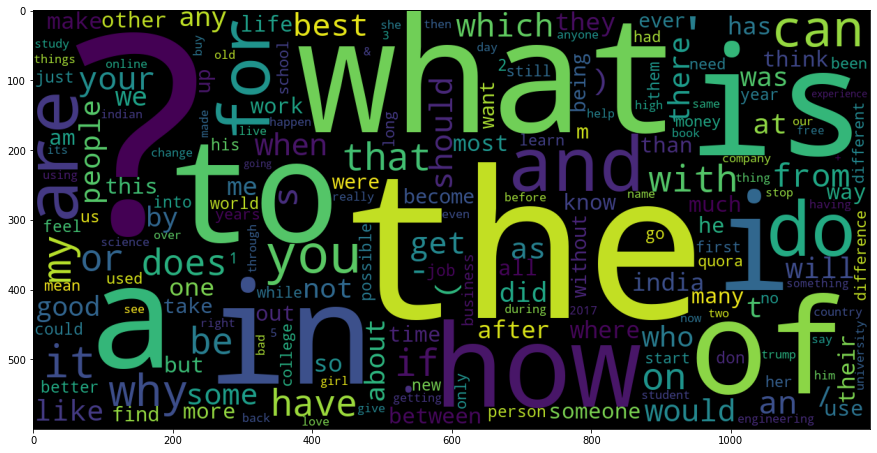

In [21]:
neg_vocab = get_word_count(train_csv_tokenized.loc[train_csv_tokenized['target'] == 0, 'question_text'].values)

plt.figure(figsize=(15,8))
plt.imshow(WordCloud(width=1200, height=600, stopwords=STOPWORDS).generate_from_frequencies(neg_vocab))

# Model building

## Build vocabulary and get embeddings

In [22]:
%%time
from torchtext.vocab import build_vocab_from_iterator

vocab = build_vocab_from_iterator(train_csv_tokenized['question_text'], specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

CPU times: user 5.94 s, sys: 66.2 ms, total: 6.01 s
Wall time: 6.01 s


In [23]:
vocab.get_itos()[:20]

['<unk>',
 '?',
 'the',
 'what',
 'is',
 'a',
 'to',
 'in',
 'of',
 'i',
 'how',
 'and',
 'do',
 'are',
 'for',
 'you',
 'can',
 "'",
 'why',
 'it']

In [24]:
%%time
embed_vecs = glove.get_vecs_by_tokens(vocab.get_itos())

CPU times: user 2.1 s, sys: 232 ms, total: 2.33 s
Wall time: 2.35 s


## Split the data

In [25]:
SEED = 78
VAL_SPLIT = 0.9
MAX_SEQ_LEN = 60

# Shuffle, truncate and divide into train and validation sets
train_size = int(len(train_csv_tokenized) * VAL_SPLIT)
train_val = train_csv_tokenized.sample(frac=1, random_state=SEED)
train_set = train_val[:train_size]
val_set   = train_val[train_size:]
test_set = test_csv_tokenized

In [26]:
def truncate(txt: list):
    return txt[:min(MAX_SEQ_LEN, len(txt))]

def collate_train_batch(batch):
    x_s, y_s = [], []

    for text, label in batch:
        y_s.append(label)
        
        x = torch.zeros(MAX_SEQ_LEN, dtype=torch.int32)
        processed_text = vocab(truncate(text))
        x[:len(processed_text)] = torch.tensor(processed_text, dtype=torch.int32)
        x_s.append(x)

    y_s = torch.tensor(y_s, dtype=torch.int32)
    x_s = torch.stack(x_s, dim=0)
    return x_s, y_s

"""def collate_test_batch(batch):
    ids, x_s = [], []
    
    for idx, text in batch:
        ids.append(label)
        
        x = torch.zeros(MAX_SEQ_LEN, dtype=torch.int32)
        processed_text = vocab(truncate(text))
        x[:len(processed_text)] = torch.tensor(processed_text, dtype=torch.int32)
        x_s.append(x)

    x_s = torch.stack(x_s, dim=0)
    return ids, x_s"""

'def collate_test_batch(batch):\n    ids, x_s = [], []\n    \n    for idx, text in batch:\n        ids.append(label)\n        \n        x = torch.zeros(MAX_SEQ_LEN, dtype=torch.int32)\n        processed_text = vocab(truncate(text))\n        x[:len(processed_text)] = torch.tensor(processed_text, dtype=torch.int32)\n        x_s.append(x)\n\n    x_s = torch.stack(x_s, dim=0)\n    return ids, x_s'

In [27]:
from torch.utils.data import DataLoader, TensorDataset

BATCH_SIZE = 1024

train_dl = DataLoader(
    list(zip(train_set['question_text'], train_set['target'])), 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    collate_fn=collate_train_batch)

valid_dl = DataLoader(
    list(zip(val_set['question_text'], val_set['target'])), 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    collate_fn=collate_train_batch)

In [28]:
class ClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        global vocab
        self.embedding_dim = 300
        self.hidden_dim = 50 # TODO: change to 50
        
        # Embedding layer with learning turned off
        self.emb = nn.Embedding(
            num_embeddings = len(vocab), 
            embedding_dim = self.embedding_dim,
            padding_idx = 0,
            sparse = False
        )
        self.emb.weight = nn.Parameter(embed_vecs)
        self.emb.weight.requires_grad = False
        
        # Bidirectional LSTM (2 LSTM layers took too long to train)
        self.lstm = nn.LSTM(
            input_size = self.embedding_dim,
            hidden_size = self.hidden_dim, 
            bias = True,
            batch_first = True,
            bidirectional = True
        )
        
        # Flatten + final linear layer
        self.flatten = nn.Flatten()
        self.lin = nn.Linear(
            in_features  = self.hidden_dim * MAX_SEQ_LEN * 2, 
            out_features = 1, 
            bias = True
        )

    def forward(self, inp):
        emb_output = self.emb(inp)
        #print('Embedding: ', emb_output.shape)
        
        h0 = torch.zeros(2, inp.size(0), self.hidden_dim, device=inp.device)
        c0 = torch.zeros(2, inp.size(0), self.hidden_dim, device=inp.device)
        #print('Lstm args: ', h0.shape, c0.shape)
        
        lstm_output, _ = self.lstm(emb_output, (h0, c0))
        #print('LSTM: ', lstm_output.shape)
        
        # Flatten the vectors
        lstm_output = self.flatten(lstm_output)
        #print('LSTM flat:', lstm_output.shape)
        
        last = self.lin(lstm_output)
        #print('Final: ', last.shape)
        
        return last

In [29]:
ClassifierModel()

ClassifierModel(
  (emb): Embedding(199680, 300, padding_idx=0)
  (lstm): LSTM(300, 50, batch_first=True, bidirectional=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin): Linear(in_features=6000, out_features=1, bias=True)
)

In [30]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [31]:
def train_loop(model, epochs: int = 20):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    loss_fn = nn.BCEWithLogitsLoss(reduction='mean')
    print("Training started.")
    
    for epoch in range(epochs):
        start_time = time.time()
        for i, (x, y) in enumerate(train_dl):
            optimizer.zero_grad()
            y_pred = model(x)
            loss = loss_fn(y_pred, y.unsqueeze(1).float())
            loss.backward()
            optimizer.step()
            
        train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0
        for x_train, y_train in train_dl:
            train_pred = model(x_train)
            train_loss += loss_fn(train_pred, y_train.unsqueeze(1).float()).item()
            #train_acc += calc_accuracy(y_train, train_pred)

        for x_val, y_val in valid_dl:
            val_pred = model(x_val)
            val_loss += loss_fn(val_pred, y_val.unsqueeze(1).float()).item()
            #val_acc += calc_accuracy(y_val, val_pred)"

        elapsed_time = time.time() - start_time

        print('Epoch: ', epoch + 1, 
              #'\tIter: ', i + 1, 
              '\tLoss: {:.9f}'.format(train_loss / len(train_dl)),
              #'\tAccuracy: {:.3f}%'.format(train_acc / len(train_dl)),
              '\tVal Loss: {:.9f}'.format(val_loss / len(valid_dl)),
              #'\tVal Accuracy: {:.3f}%'.format(val_acc / len(valid_dl)),
              '\tTime: {:.3f}s'.format(elapsed_time))
    
    print('Training ended.')

In [32]:
torch.manual_seed(SEED)
model = ClassifierModel()
train_loop(model, epochs=5)

Training started.
Epoch:  1 	Loss: 0.113381444 	Val Loss: 0.112837426 	Time: 1398.878s
Epoch:  2 	Loss: 0.099875881 	Val Loss: 0.101200821 	Time: 1423.490s
Epoch:  3 	Loss: 0.095958523 	Val Loss: 0.099901214 	Time: 1385.907s
Epoch:  4 	Loss: 0.092847747 	Val Loss: 0.098733785 	Time: 1442.918s
Epoch:  5 	Loss: 0.089279817 	Val Loss: 0.098111337 	Time: 1389.049s
Training ended.


# Picking f1 threshold and returning the answer

In [33]:
from sklearn.metrics import f1_score

def best_threshold(y_train, train_preds):
    cur_score, max_score, threshold = 0, 0, 0
    for i in tqdm(np.arange(0.1, 1, 0.01)):
        cur_score = f1_score(y_train.astype(int), (train_preds > i).astype(int))
        if cur_score > max_score:
            threshold = i
            max_score = cur_score
            
    print('Best threshold is {:.4f} with F1 score: {:.4f}'.format(threshold, max_score))
    
    return threshold

In [34]:
def collate_predict_batch(batch):
    x_s = []

    for text in batch:       
        x = torch.zeros(MAX_SEQ_LEN, dtype=torch.int32)
        processed_text = vocab(truncate(text))
        x[:len(processed_text)] = torch.tensor(processed_text, dtype=torch.int32)
        x_s.append(x)
    
    x_s = torch.stack(x_s, dim=0)
    return x_s

In [35]:
# Dataloader for calculating f1 threshold
train_val_predict_dl = DataLoader(
    list(train_val['question_text']),
    batch_size = BATCH_SIZE,
    shuffle = False,
    collate_fn = collate_predict_batch)

In [36]:
%%time
# Calculate predictions on train and validation sets
train_val_predictions = np.array([])
for x in tqdm(train_val_predict_dl):
    train_val_predictions = np.concatenate((train_val_predictions, sigmoid(model(x).detach().numpy())[:, 0]))
train_val_predictions

100%|██████████| 1276/1276 [06:58<00:00,  3.05it/s]

CPU times: user 13min 11s, sys: 17.6 s, total: 13min 29s
Wall time: 6min 58s


array([0.00468806, 0.00319742, 0.00241498, ..., 0.00279783, 0.00040055,
       0.00024525])

In [37]:
# Get most optimal f1 threshold
THRESHOLD = best_threshold(np.array(train_val['target'].values), train_val_predictions)

100%|██████████| 90/90 [00:53<00:00,  1.69it/s]

Best threshold is 0.3400 with F1 score: 0.7065


In [38]:
train_val['prediction'] = (train_val_predictions > THRESHOLD).astype(int)

In [39]:
from sklearn.metrics import confusion_matrix

# See confusion matrix
confusion_matrix(train_val['target'], train_val['prediction'])

array([[1193777,   31535],
       [  19444,   61366]])

In [40]:
# False positive example
train_val[(train_val['prediction'] == 1) & (train_val['target'] == 0)].head(5)['question_text'].values

array([list(['are', 'muslim', '/', 'middle', 'eastern', 'soldiers', 'of', 'the', 'united', 'states', 'army', 'discriminated', 'against', 'by', 'fellow', 'soldiers', 'when', 'deployed', 'in', 'the', 'middle', 'east', '?']),
       list(['why', 'is', 'it', 'seen', 'as', 'unacceptable', 'if', 'black', 'people', 'wear', 'blue', '?']),
       list(['why', 'do', 'you', 'think', 'there', 'are', 'only', 'two', 'genders', '?', '(', 'or', 'lack', 'thereof', ')', '?']),
       list(['why', 'we', 'indians', 'are', 'obsessed', 'of', 'foreign', 'goods', '?']),
       list(['why', 'do', 'people', 'try', 'and', 'disassociate', 'homosexuality', 'and', 'hiv', '?', 'according', 'to', 'the', 'cdc', 'an', 'estimated', '70', '%', 'of', 'infections', 'occur', 'among', 'the', 'homosexual', 'community', '.', 'if', 'not', 'curtailed', 'will', 'we', 'all', 'one', 'day', 'have', 'hiv', '?', 'why', 'does', 'western', 'society', 'support', 'a', 'health', 'disaster', '?'])],
      dtype=object)

In [41]:
# False negative example
train_val[(train_val['prediction'] == 0) & (train_val['target'] == 1)].head(5)['question_text'].values

array([list(['to', 'all', 'you', 'who', 'whined', 'like', 'toddlers', 'that', 'the', 'dossier', 'had', 'nothing', 'to', 'do', 'with', 'the', 'fisa', 'warrant', 'explain', 'this', 'please', '?']),
       list(['can', 'i', 'start', 'a', 'religion', 'where', 'the', 'main', 'focus', 'is', 'hating', 'sergey', 'brin', '?']),
       list(['had', 'gandalf', 'not', 'led', 'a', 'military', 'coup', 'against', 'president', 'sauron', 'would', 'he', 'have', 'been', 'elected', 'to', 'a', 'second', 'term', '?']),
       list(['reasons', 'of', 'why', 'is', 'it', 'legal', 'to', 'beat', 'a', 'school', 'learner', '?']),
       list(['if', 'i', 'object', 'to', 'affirmative', 'action', 'gay', 'marriage', 'and', 'illegal', 'immigration', 'how', 'does', 'calling', 'me', 'racist', 'or', 'homophobic', 'help', 'change', 'my', 'views', '?'])],
      dtype=object)

## Calculate test set answers

In [42]:
%%time
test_dl = DataLoader(
    list(test_set['question_text']),
    batch_size = BATCH_SIZE,
    shuffle = False,
    collate_fn = collate_predict_batch)

test_predictions = np.array([])
for x in tqdm(test_dl):
    test_predictions = np.concatenate((test_predictions, sigmoid(model(x).detach().numpy())[:, 0] > THRESHOLD))

100%|██████████| 367/367 [02:06<00:00,  2.90it/s]

CPU times: user 3min 54s, sys: 9.64 s, total: 4min 4s
Wall time: 2min 6s


In [43]:
ans = pd.DataFrame(columns=['qid', 'prediction'])
ans['qid'] = test_set['qid']
ans['prediction'] = test_predictions.astype(int)
ans

,qid,prediction
0,0000163e3ea7c7a74cd7,1
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0
...,...,...
375801,ffff7fa746bd6d6197a9,0
375802,ffffa1be31c43046ab6b,0
375803,ffffae173b6ca6bfa563,0
375804,ffffb1f7f1a008620287,0


In [44]:
ans.to_csv('submission.csv', index=False)